* **StandardScaler**: for features that have normal distribution. Standardization: rescalling the distribution values so that the mean of observed values is 0 and std=1
* **MinMaxScaler**: when upper and lower boundaries are well known. Normalization, is rescaling the data to lay in [0,1] range

Overlap takes 0.6 sec

In [1]:
# https://www.kaggle.com/code/mineshjethva/timeseries-anomaly-detection-using-rnn-autoencoder/notebook
# https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import pandas as pd
from pickle import load
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from pickle import dump
from sklearn.metrics import classification_report,average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, f1_score, confusion_matrix, auc

2023-03-27 20:02:24.531844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 20:02:24.597471: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 20:02:24.599380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-03-27 20:02:24.599387:

In [2]:
# MODEL_PATH = './GoogleColab/Lstm_newModel_1_repeat_with_30average'
MODEL_PATH = './Thesis/AfterThesis4'
# MODEL_PATH = './spiral/Elad_suggestion/100Spiral_new_noDrop'
# MODEL_PATH = './spiral/15March/Version3'
# MODEL_PATH = './spiral/train/Lstm_BigPeg_80Train'


# SCALER_PATH = './spiral/Elad_suggestion/Elad_100/100_spiral_MinMax.pkl'
# SCALER_PATH = './GoogleColab/Normalizing_window30.pkl'
# SCALER_PATH = './spiral/train/BigPegNormalized80.pkl'

feature_list = ['Fx','Fy','Fz','Mx','My']
TIMESTEP = 50
preprocess = False
use_new_features = False
# rolling mean
window = 40

In [3]:
model = keras.models.load_model(MODEL_PATH)
if preprocess:
    scaler = load(open(SCALER_PATH, 'rb'))
    print('Scaler Loaded')
    print(scaler)

2023-03-27 20:03:16.563852: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/user/.mujoco/mujoco200/bin:/home/user/.mujoco/mujoco200/bin
2023-03-27 20:03:16.563863: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 20:03:16.563872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux-n8-room20): /proc/driver/nvidia/version does not exist
2023-03-27 20:03:16.564059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [4]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 LSTM_1 (LSTM)                  (None, 64)           17920       ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 64)           0           ['LSTM_1[0][0]']                 
                                                                                                  
 lambda_1 (Lambda)              (None, None, 64)     0           ['dropout_1[0][0]',              
                                                                  'input_2[0][0]']          

## 1. Testing on test data (including anomalies) 

### Loop testing

In [5]:
def sorted_repeated_values(arr, N):
    # Use the numpy unique method to get the unique values and their frequency
    unique, counts = np.unique(arr, return_counts=True)
    
    # Find the values that are repeated at least N times
    repeated = unique[counts >= N]
    
    # Sort the repeated values and return them
    return np.sort(repeated)

def to_sequence(data, timesteps=1):
    n_features=data.shape[2]
    seq = []
    for i in range(len(data)-timesteps):
        # takes a window of data of specified timesteps
        temp = data[i:(i+timesteps)]
        temp = temp.reshape(timesteps, n_features)
        seq.append(temp)
        
    return np.array(seq)

def circle_check(peg_x,peg_y):
    # old
    hole_x = -0.1379
    hole_y = -0.5095
    
    # new
#     hole_x = -0.1384
#     hole_y = -0.5078
    
    error = np.sqrt((peg_x - hole_x) ** 2 + (peg_y - hole_y) ** 2)
    return error

def new_features(df):
    Fxy = np.linalg.norm(df[['Fx','Fy']].values,axis=1).tolist()
    Mxy = np.linalg.norm(df[['Mx','My']].values,axis=1).tolist()
    theta_Fxy = np.arctan2(df['Fy'], df['Fx']).tolist()
    theta_Mxy = np.arctan2(df['My'], df['Mx']).tolist()
    df.insert(2, "Fxy", Fxy, True)
    df.insert(3, "Mxy", Mxy, True)
    df.insert(4, "theta_Fxy", theta_Fxy, True)
    df.insert(5, "theta_Mxy", theta_Mxy, True)
    df = df[['Fxy','theta_Fxy','Fz','Mxy','theta_Mxy']]
    return df

In [41]:
# robotdatacollection3_part2
testing_ideces = [1,2,3,4,6,7,8,10,15,17,22,24,25,28,30,32,33,34,38,40,41,44,
                  43,46,47,52,53,54,60,62,66,68,70,71,73,77,82,84,90,92,97,98]
print(len(testing_ideces))

# evaluation_set2
# testing_ideces = [6,7,8,13,15,23,25,29,31,36,38,45,48,49]
# print(len(testing_ideces))

# robotdatacollection3
# testing_ideces = [1,9,11,29,60,63,66,70,79,86]
# print(len(testing_ideces))


# testing_ideces = [5,8,9,11,15,25,27,33,34,35,36,40,48,49]

42


In [42]:
MODEL_PATH

'./GoogleColab/Lstm_newModel_1_repeat_with_30average'

In [43]:
thresholds = [0.12058696399818704, 0.17141290128585543, 0.14004766570118113, 0.16121761305331384, 0.17772109423329138]
max_threshold = max(thresholds)

In [44]:
dt = 1/125
time_sec = 5
index_cut = int(time_sec/dt)
majority_errors = []
single_errors = []
start_points = []
majority_idx = []
data_len = []

for i in testing_ideces: #range(1, 50+1):#testing_ideces:#range(1, 50+1): #testing_ideces: #range(1, 50+1): #range(1, 4+1):#testing_ideces: #range(1, 50+1):#testing_ideces:#r
#     file_name = "./spiral/spiral2/ep{}.csv".format(i)
#     file_name = "./spiral/x4.8_1.2/ep{}.csv".format(i)
    file_name = "./robotdatacollection3_part2/ep{}.csv".format(i)
#     file_name = "./evaluation_set2/ep{}.csv".format(i)

    df_original = pd.read_csv(file_name)
    # collect init point
#     x_start = -0.1379 - df_original.x[0]
#     y_start = -0.5095 -df_original.y[0]
#     start = [x_start,y_start]
#     start_points.append(start)
    # cut first 4 sec
    df_original = df_original.drop(range(index_cut)).reset_index(drop=True)
    one_occurace = np.where(df_original.Case == 1)[0]
    print('#######################')
    print(file_name)
    print('#######################')
    print('One Occurance')
    print(one_occurace)
    # reformat test set to sequence
    df_test = df_original[feature_list]
    if use_new_features:
        df_test = new_features(df_test)
    data_len.append(df_original.t.iloc[len(df_original)-1])
    
    if preprocess:
        df_test = df_test.rolling(window).mean()
        # due to the moving average we the first (window-1) rows become NaN so we remove them
        df_test = df_test.loc[window-1:]
        names = df_test.columns
        df_test[names] = scaler.transform(df_test[names])
        print('Data Normalized')
    
    df_test = np.expand_dims(df_test, axis=1)
    x_test = to_sequence(df_test, timesteps=TIMESTEP)
    
    # Get test MAE loss.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

    #using individual threshold
    anomalies_list = []
    anomalies_idx_list = []
    for i in range(test_mae_loss.shape[1]):
        temp_anomaly = (test_mae_loss[:,i] > thresholds[i]).tolist()
#         temp_anomaly = (test_mae_loss[:,i] > max_threshold).tolist()
        anomalies_list.append(temp_anomaly)
        anomalies_idx_list.append(np.where(temp_anomaly)[0])

    all_indexes = np.concatenate(anomalies_idx_list)
    
    # finding earliest detection of anomaly for each feature separately
    smallest_idx_list = []
    for i in range(test_mae_loss.shape[1]):
        if anomalies_idx_list[i].size <= 0:
            continue
        else: 
            min_index = min(anomalies_idx_list[i])
            smallest_idx_list.append(min_index)
    if smallest_idx_list:
        smallest_idx = min(smallest_idx_list)
        print('Smallest index: ',smallest_idx)
        peg_x = df_original.x.loc[smallest_idx]
        peg_y = df_original.y.loc[smallest_idx]
        single_error = circle_check(peg_x,peg_y)
    else:
        print('All arrays are empty')  
        single_error = 0
        
    single_errors.append(single_error)

    print('-----Majority index---------')
    majority_index = sorted_repeated_values(all_indexes, 2)
    

    if any(majority_index):
        print(majority_index)
        start = min(majority_index)
        end = max(majority_index)

        peg_x = df_original.x.loc[start]
        peg_y = df_original.y.loc[start]
        majority_error = circle_check(peg_x,peg_y)
        
        majority_idx.append(majority_index[0])
#         data_len.append(len(df_test))
    else:
        print('Empty')
        majority_error = 0
        majority_idx.append(0)
#         data_len.append(0)
        
    majority_errors.append(majority_error)
#     print(majority_idx)
#     print(data_len)

#######################
./robotdatacollection3_part2/ep1.csv
#######################
One Occurance
[3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 3201
 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213 3214 3215
 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228 3229
 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241 3242 3243
 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255 3256 3257
 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267 3268 3269 3270 3271
 3272 3273 3274 3275 3276 3277 3278 3281 4876 4877 4878 4879 4880 4881
 4882 4883 4884 4885 4886 4887 4888 4889 4890 4891 4892 4893 4894 4895
 4896 4897 4898 4899 4900 4901 4902 4903 4904 4905 4906 4907 4908]
Data Normalized
151/151 [==============================] - 2s 9ms/step
Smallest index:  3262
-----Majority index---------
[3262 3263 3264 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275
 3276 3277 3278 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289
 3

156/156 [==============================] - 1s 8ms/step
Smallest index:  3384
-----Majority index---------
[3386 3387 3388 3389 3390 3391 3392 3393 3394 3395 3396 3397 3398 3399
 3400 3401 3402 3403 3404 3405 3406 3407 3408 3409 3410 3411 3412 3413
 3414 3415 3416 3417 3418 3419 3420 3421 3422 3423 3424 3425 3426 3427
 3428 3429 3430 3431 3432 3433 3434 3435 3436 3437 3438 3439 3440 3441
 3442 3443 3444 3445 3446 3447 3448 3449 3450 3451 3452 3453 3454 3455
 3456 3457 3458 3459 3460 3461 3462 3463 3464 3465 3466 3467 3468 3469
 3470 3471 3472 3473 3474 3475 3476 3477 3478 3479 3480 3481 3482 3483
 3484 3485 3486 3487 3488 3489 3490 3491 3492 3493 3494 3495 3496 3497
 3498 3499 3500 3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511
 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525
 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539
 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553
 3554 3555 3556 3557 3558 3559 3560 3561 3

#######################
./robotdatacollection3_part2/ep24.csv
#######################
One Occurance
[2930 2931 2932 2933 2934 2935 2936 2937 2938 2939 2940 2941 2942 2943
 2944 2945 2946 2947 2948 2949 2950 2951 2952 4514 4516 4517 4518 4519
 4520 4521 4522 4523 4524 4525 4526 4527 4528 4529 4530 4531 4532 4533
 4534 4535 4536 4537 4538 4539 4540 4541 4542 4543 4544 4545 4546 4547
 4548 4549]
Data Normalized
140/140 [==============================] - 1s 10ms/step
Smallest index:  2926
-----Majority index---------
[2939 2940 2941 2942 2943 2944 2945 2946 2947 2948 2949 2950 2951 2952
 2953 2954 2955 2956 2957 2958 2959 2960 2961 2962 2963 2964 2965 2966
 2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977 2978 2979 2980
 2981 2982 2983 2984 2985 2986 2987 2988 2989 2990 2991 2992 2993 2994
 2995 2996]
#######################
./robotdatacollection3_part2/ep25.csv
#######################
One Occurance
[3455 3458 3459 3460 3461 3462 3463 3464 3465 3466 3467 3468 3469 3470
 3471 3472 347

155/155 [==============================] - 1s 8ms/step
Smallest index:  3371
-----Majority index---------
[3372 3373 3374 3375 3376 3377 3378 3379 3380 3381 3382 3383 3384 3385
 3386 3387 3388 3389 3390 3391 3392 3393 3394 3395 3396 3397 3398 3399
 3400 3401 3402 3403 3404 3405 3406 3407 3408 3409 3410 3411 3412 3413
 3414 3415 3416 3417 3418 3419 3420 3421 3422 3423 3424 3425 3426 3427
 3428 3429 3430 3431 3432 3433 3434 3435 3436 3437 3438 3439 3440 3441
 3442 3443 3444 3445 3446 3447 3448 3449 3450 3451 3452 3453 3454 3455
 3456 3457 3458 3459 3460 3461 3462 3463 3464 3465 3466 3467 3468 3469
 3470 3471 3472 3473 3474 3475 3476 3477 3478 3479 3480 3481 3482 3483
 3484 3485 3486 3487 3488 3489 3490 3491 3492 3493 3494 3495 3496 3497
 3498 3499 3500 3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511
 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525
 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539
 3540 3541 3542 3543 3544 3545 3546 3547 3

154/154 [==============================] - 1s 8ms/step
Smallest index:  3329
-----Majority index---------
[3340 3341 3342 3343 3344 3345 3346 3347 3348 3349 3350 3351 3352 3353
 3354 3355 3356 3357 3358 3359 3360 3361 3362 3363 3364 3365 3366 3367
 3368 3369 3370 3371 3372 3373 3374 3375 3376 3377 3378 3379 3380 3381
 3382 3383 3384 3385 3386 3387 3388 3389 3390 3391 3392 3393 3394 3395
 3396 3397 3398 3399 3400 3401 3402 3403 3404 3405 3406 3407 3408 3409
 3410 3411 3412 3413 3414 3415 3416 3417 3418 3419 3420 3421 3422 3423
 3424 3425 3426 3427 3428 3429 3430 3431 3432 3433 3434 3435 3436 3437
 3438 3439 3440 3441 3442 3443 3444 3445 3446 3447 3448 3449 3450 3451
 3452 3453 3454 3455 3456 3457 3458 3459 3460 3461 3462 3463 3464 3465
 3466 3467 3468 3469 3470 3471 3472 3473 3474 3475 3476 3477 3478 3479
 3480 3481 3482 3483 3484 3485 3486 3487 3488 3489 3490 3491 3492 3493
 3494 3495 3496 3497 3498 3499 3500 3501 3502 3503 3504 3505 3506 3507
 3508 3509 3510 3511 3512 3513 3514 3515 3

159/159 [==============================] - 1s 8ms/step
Smallest index:  3473
-----Majority index---------
[3476 3477 3478 3479 3480 3481 3482 3483 3484 3485 3486 3487 3488 3489
 3490 3491 3492 3493 3494 3495 3496 3497 3498 3499 3500 3501 3502 3503
 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517
 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531
 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545
 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559
 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573
 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587
 3588 3589 3590 3591 3592 3593 3594 3595 3596]
#######################
./robotdatacollection3_part2/ep92.csv
#######################
One Occurance
[3333 3334 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344 3345 3346
 3347 3348 3349 3350 3351 3352 3353 3354 3355 3356 3357 3358 3359 3360
 3361 3362 3363 3364 3365 3366 3367 3

In [45]:
len(majority_errors)

42

In [46]:
#combine 2 lists into dataframe
cols = np.array(testing_ideces)
errors_df = pd.DataFrame({'single_error':single_errors, 'majority_error':majority_errors})
errors_df = errors_df.set_index(cols)

In [47]:
errors_df

,single_error,majority_error
1,0.000585,0.000585
2,0.000457,0.000452
3,0.000534,0.000582
4,0.000709,0.000712
6,0.000782,0.000000
7,0.000614,0.000631
8,0.000457,0.000467
10,0.000530,0.000000
15,0.000458,0.000464
17,0.000585,0.000599


In [48]:
zeros_count = errors_df.majority_error[errors_df.majority_error == 0].count()
print(zeros_count)

9


In [49]:
bigger_majority = errors_df.majority_error[errors_df.majority_error >= 0.0007].count()
bigger_single = errors_df.single_error[errors_df.single_error >= 0.0007].count()
print(f"There are {zeros_count} cases where overlap wasnt detected")
print(f"There are {bigger_majority} values >= 0.0007 in the majority errors")
print(f"There are {len(errors_df)-bigger_majority-zeros_count} values < 0.0007 in the majority errors")
print()
print(f"There are {bigger_single} values >= than 0.0007 in the single errors")
print(f"There are {len(errors_df)-bigger_single-zeros_count} values < 0.0007 in the single errors")

There are 9 cases where overlap wasnt detected
There are 3 values >= 0.0007 in the majority errors
There are 30 values < 0.0007 in the majority errors

There are 7 values >= than 0.0007 in the single errors
There are 26 values < 0.0007 in the single errors


In [50]:
pd.DataFrame(errors_df.majority_error[errors_df.majority_error >= 0.0007])

,majority_error
4,0.000712
60,0.000748
68,0.000813


In [32]:
pd.DataFrame(errors_df.majority_error[errors_df.majority_error == 0.0])

,majority_error
6,0.0
10,0.0
32,0.0
34,0.0
43,0.0
47,0.0
62,0.0
97,0.0
98,0.0


In [ ]:
df = pd.read_csv('./robotdatacollection3_part2/ep1.csv')
start_idx = df.index[df['Case'].diff() == 1].tolist()

In [ ]:
start_idx

### Analayzing cases

In [ ]:
df = pd.read_csv('./spiral/bigPeg_pitch1_error4to6/ep6.csv')
one_occurace = np.where(df.Case == 1)[0]

In [ ]:
len(df)

In [ ]:
def plot(name, show_label):
    plt.figure(figsize=(15,5))
    plt.title(name)
    plt.plot(df.t, df[name])
    if show_label:
        for i in one_occurace:
            plt.scatter(df.t.loc[i], df[name].loc[i],marker='*', color='red', zorder=12, alpha=0.2)
    plt.grid()
    plt.show()

In [ ]:
for f in feature_list:
    plot(f, True)
    
plt.figure(figsize=(15,5))
plt.scatter(df.t, df.Case)
plt.grid()
plt.show()

# ====================================================++

## 7. Testing one by one

In [6]:
feature_list = ['Fx','Fy','Fz','Mx','My']

In [7]:
dt = 1/125
time_sec = 4
index_cut = int(time_sec/dt)
print(index_cut)
# verify 
# print(df_original.t.iloc[index_cut]-df_original.t.iloc[0])

500


In [45]:
df_testing_data = pd.read_csv('./Thesis/spiral6/ep14.csv')
# df_testing_data = pd.read_csv('./robotdatacollection3_part2/ep2.csv')

In [46]:
df_testing_data = df_testing_data.drop(range(index_cut)).reset_index(drop=True)

In [47]:
one_occurace = np.where(df_testing_data.Case == 1)[0]
print(one_occurace)

[2411 2412 2413 2414 2415 2416 2417 2418 2419 2420 2421 2422 2423 2424
 2425 2426 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 2437 2438
 2439 2440 2441 2442 2443 2444 2445 2446 2447 2449 2451 2452 2453 2455
 2457 3865 3866 3867 3868 3869 3870 3871 3872 3873 3874 3875 3876 3877
 3878 3879 3880 3881 3882 3883 3884 3885 3886 3887 3888 3889 3890 3891
 3892 3893 3894 3895 3896 3897 3898 3899 3900 3901]


In [48]:
total = len(df_testing_data)
print(total)

3902


In [49]:
x_hole = -0.1384
y_hole = -0.5078
# x_hole = -0.1379
# y_hole = -0.5095

In [50]:
for i in one_occurace:
    print(np.sqrt((df_testing_data.x.loc[i]-x_hole)**2+(df_testing_data.y.loc[i]-y_hole)**2))

0.0007942982439001258
0.0007905050617470944
0.0007859363123300953
0.0007724061299786324
0.0007837264953244233
0.0007687223813988142
0.000760728073902911
0.0007633449672539213
0.0007554981907435661
0.0007428330534389088
0.0007661076261372222
0.0007538452711333414
0.000762127829651437
0.0007487363699164613
0.0007493528107626777
0.0007534461500515944
0.0007150298706000216
0.0007207365023058928
0.0007283109439959693
0.0007005877058234093
0.0007303042479336172
0.0006988322526394325
0.0007289698954367201
0.0007103298405628142
0.0007737292934846936
0.0007379513157959674
0.0007712196277117318
0.0007319494408948851
0.0007644222754495644
0.0007345422967128467
0.0007533127753001135
0.0007676970977223368
0.0007664567213200284
0.0007555209817728799
0.0007827315639480953
0.000762189023365081
0.0007556642038149386
0.0007817031753096229
0.00078147005650312
0.0007543315748995121
0.0007590982157640796
0.0007963176437270645
0.0007945937837617823
0.0007889662525081318
0.000761625366140574
0.00078092307383

In [51]:
theta = np.linspace(0, 2*np.pi, 100)
hole_insert_x = (0.4/1000) * np.cos(theta) + x_hole
hole_insert_y = (0.4/1000) * np.sin(theta) + y_hole
imp_insert_x = (0.8/1000) * np.cos(theta) + x_hole
imp_insert_y = (0.8/1000) * np.sin(theta) + y_hole

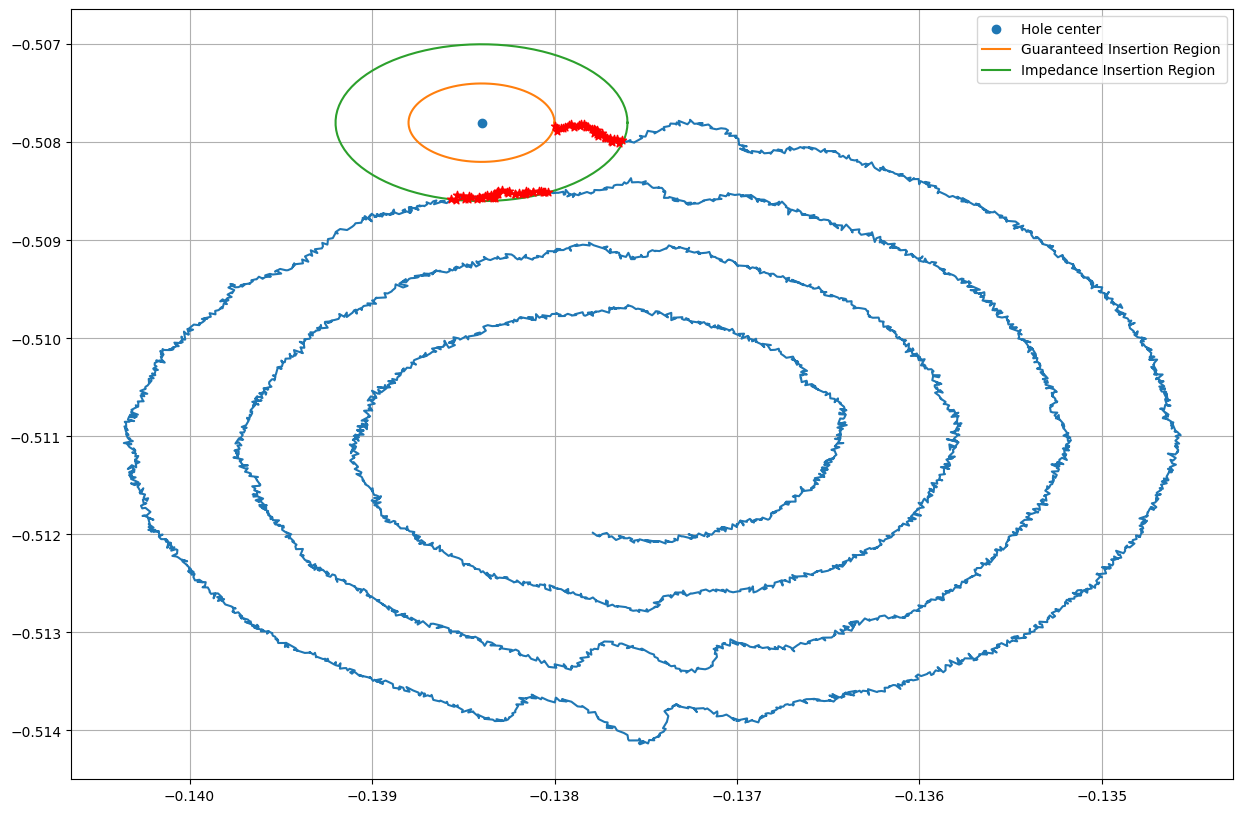

In [52]:
plt.figure(figsize=(15,10))
plt.plot(df_testing_data.x,df_testing_data.y)
for i in one_occurace:
    plt.scatter(df_testing_data.x.loc[i],df_testing_data.y.loc[i],marker='*', color='red', zorder=12)
plt.scatter(x_hole, y_hole,label='Hole center')
plt.plot(hole_insert_x,hole_insert_y,label='Guaranteed Insertion Region')
plt.plot(imp_insert_x,imp_insert_y,label='Impedance Insertion Region')
plt.grid()
plt.legend()
plt.show()


In [53]:
df_testing_data.t.loc[total-1]-df_testing_data.t.loc[0]

31.20804524421692

In [54]:
df_testing_data.t.loc[2935]-df_testing_data.t.loc[0]

23.479493856430054

In [55]:
df_testing_data.shape

(3902, 18)

In [56]:
def plot_with_labels(df, name, show_label):
    plt.figure(figsize=(10,4))
    plt.title(name)
    plt.plot(df.t, df[name])
    if show_label:
        for i in one_occurace:
            plt.scatter(df.t.loc[i], df[name].loc[i],marker='*', color='red', zorder=12, alpha=0.2)
    plt.grid()
    plt.show()

def plot_vs_time(df, name):
    plt.figure(figsize=(10,4))
    plt.title(name)
    plt.plot(df.t, df[name])
    plt.grid()
    plt.show()

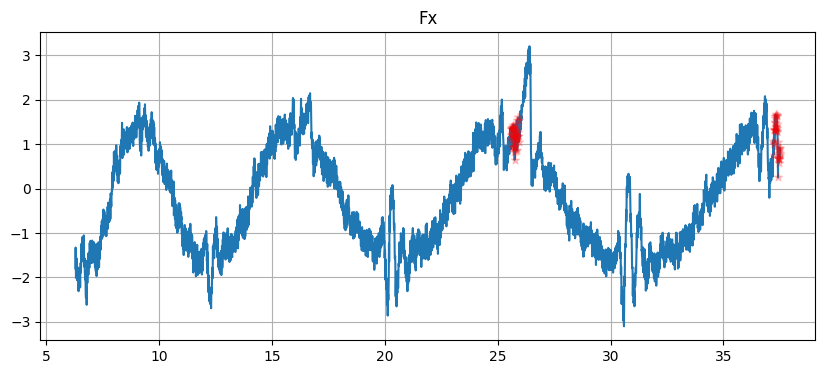

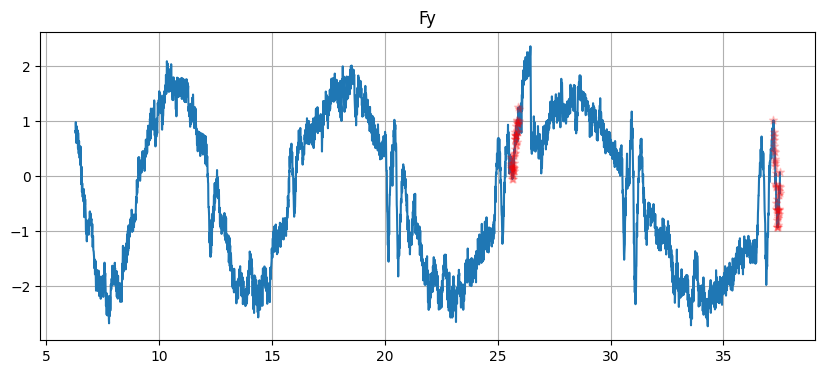

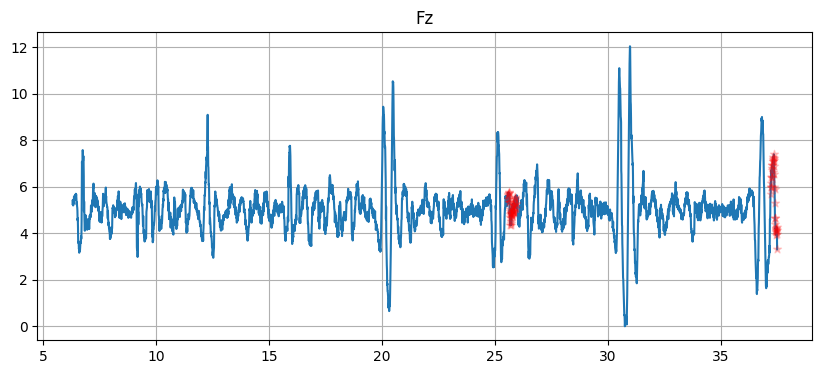

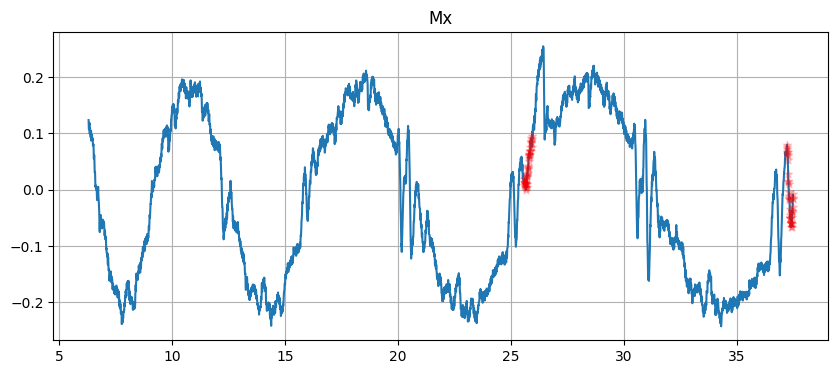

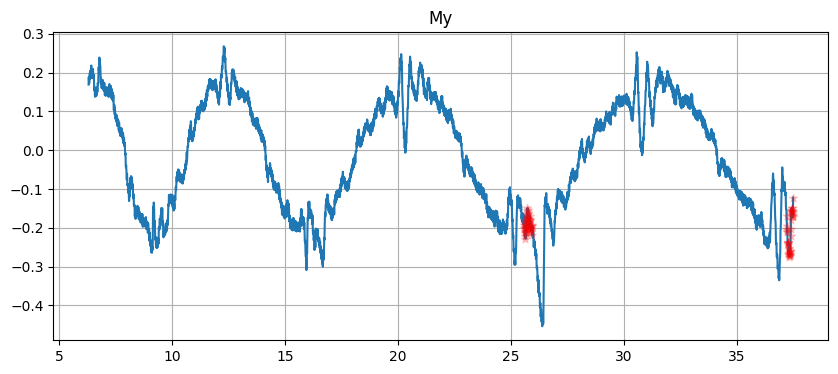

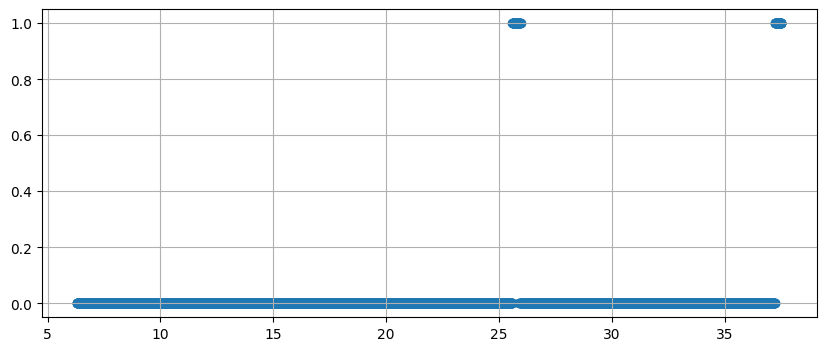

In [57]:
# we will use the original dataset which contains anomaly for testing
for f in feature_list:
    plot_with_labels(df=df_testing_data,name=f,show_label=True)
    
plt.figure(figsize=(10,4))
plt.scatter(df_testing_data.t, df_testing_data.Case)
plt.grid()

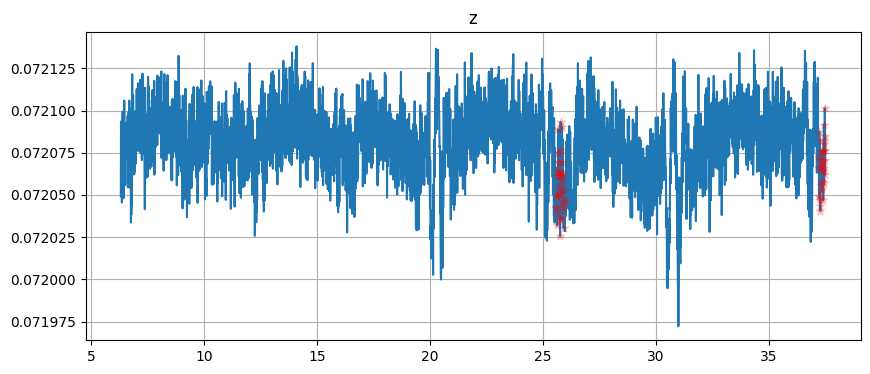

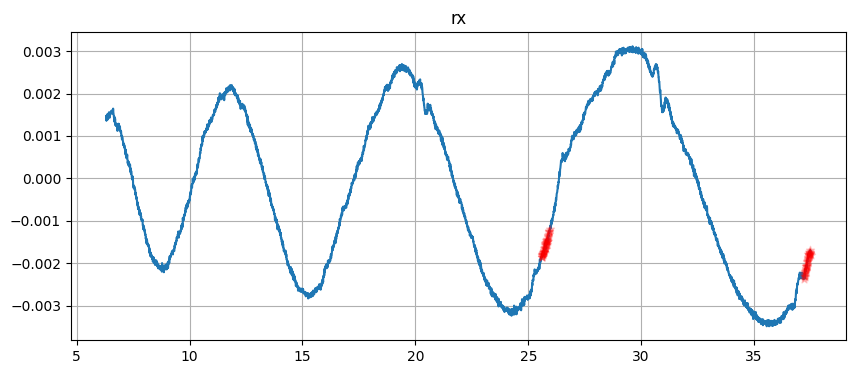

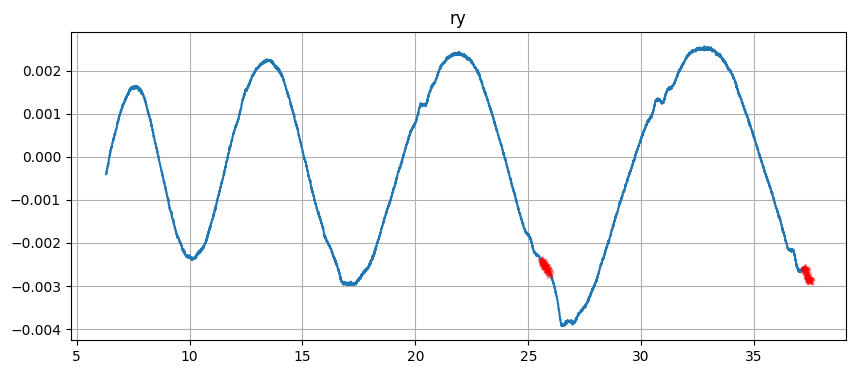

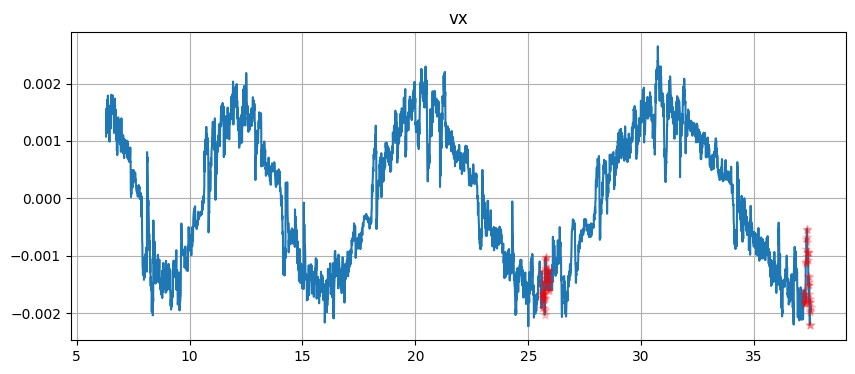

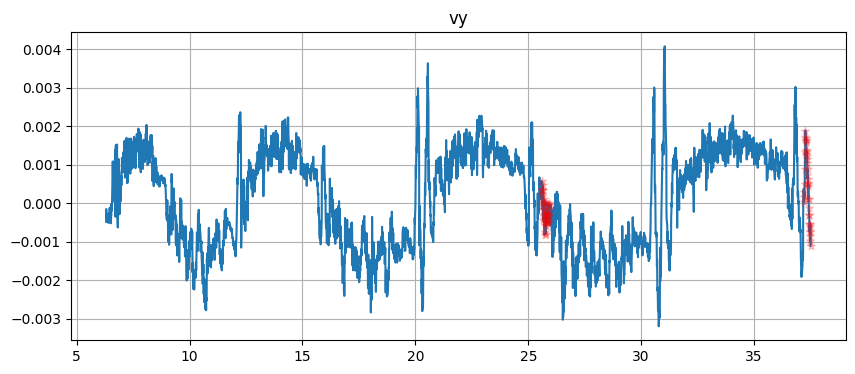

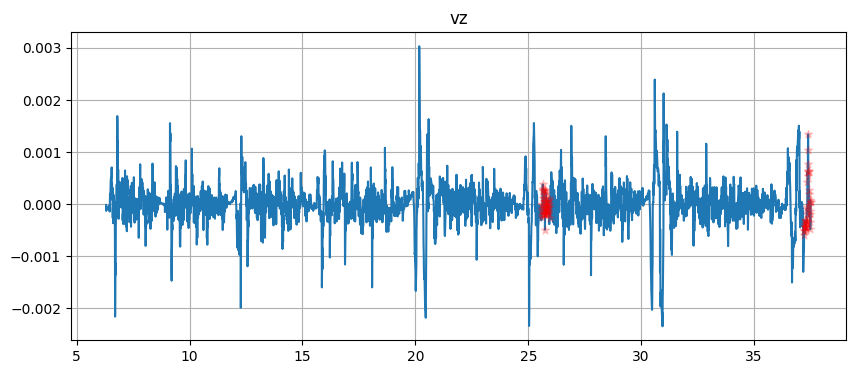

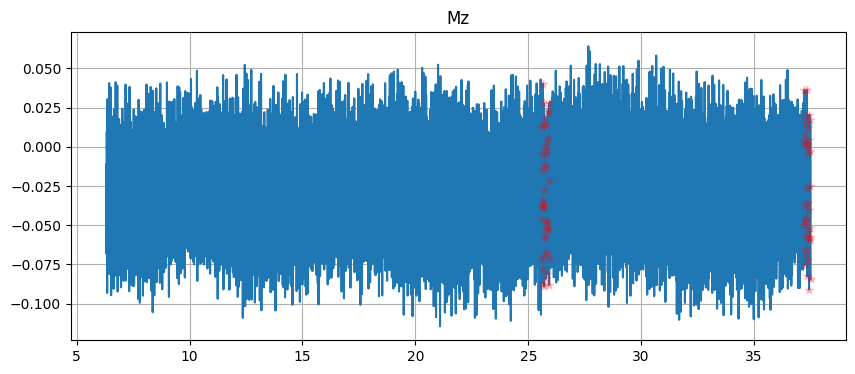

In [58]:
not_used = ['z','rx','ry','vx','vy','vz','Mz']
for f in not_used:
    plot_with_labels(df=df_testing_data,name=f,show_label=True)

### 7.1. Preparing Test Set

In [59]:
df_test = df_testing_data[feature_list]

In [60]:
if use_new_features:
    df_test = new_features(df_test)
    feature_list= ['Fxy','theta_Fxy','Fz','Mxy','theta_Mxy']

In [61]:
df_test.describe()

,Fx,Fy,Fz,Mx,My
count,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000
mean,-0.230086,-0.355090,4.999785,-0.021041,-0.016344
std,1.168112,1.332129,1.091649,0.141774,0.145474
min,-3.098387,-2.723209,-0.001878,-0.242384,-0.453921
25%,-1.251383,-1.628692,4.586776,-0.162006,-0.144168
50%,-0.332922,-0.474515,5.002403,-0.037162,-0.002554
75%,0.797814,0.841738,5.427823,0.114222,0.118036
max,3.199154,2.365190,12.042474,0.254752,0.267919


In [62]:
if preprocess:
    df_test = df_test.rolling(window).mean()
    # due to the moving average we the first (window-1) rows become NaN so we remove them
    df_test = df_test.loc[window-1:]
    names = df_test.columns
    df_test[names] = scaler.transform(df_test[names])
    display(df_test.describe())
    print('Data Normalized')

In [63]:
df_test = df_test.rolling(window).mean()
# due to the moving average we the first (window-1) rows become NaN so we remove them
df_test = df_test.loc[window-1:]

In [64]:

print(df_test.shape)
df_test = np.expand_dims(df_test, axis=1)
print(df_test.shape)

(3863, 5)
(3863, 1, 5)


In [65]:
# create sequence of the test dataset
x_test = to_sequence(df_test, timesteps=TIMESTEP)
print(f"""Shape of the datasets:
    original test data = {df_test.shape}
    sequenced test data = {x_test.shape}""")

Shape of the datasets:
    original test data = (3863, 1, 5)
    sequenced test data = (3813, 50, 5)


### 7.2. Calculating MAE Loss on the Test Set

In [66]:
# Get test MAE loss.
# x_test_pred = model.predict(df_test)
# test_mae_loss = np.mean(np.abs(x_test_pred - df_test), axis=1)
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

120/120 [==============================] - 2s 16ms/step


In [67]:
feature_list

['Fx', 'Fy', 'Fz', 'Mx', 'My']

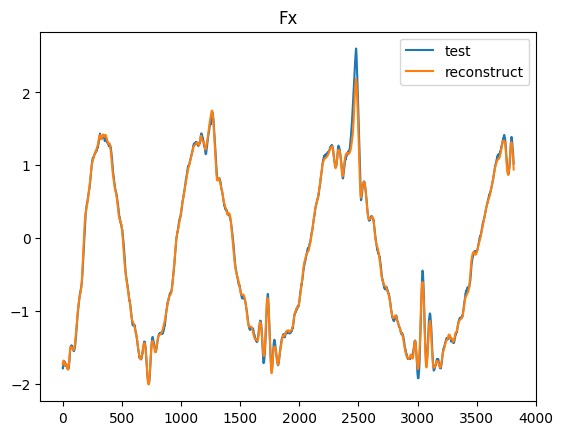

In [68]:
val = 0
plt.figure()
plt.title(feature_list[val])
plt.plot(x_test[:,1,val],label='test')
plt.plot(x_test_pred[:,1,val],label='reconstruct')
plt.legend()
plt.show()


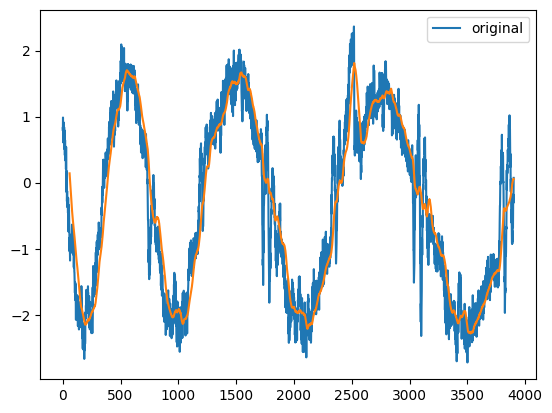

In [69]:
name='Fy'
plt.plot(df_testing_data[name],label='original')
# plt.plot(df_test[name],label='reconstruct')
plt.plot(df_testing_data[name].rolling(60).mean())
plt.legend()

Lstm_60Window_NoScaling_100spirals

In [70]:
# thres_100=  [0.18720890940402504, 0.19196973554821115, 0.308779249884391, 0.05728858178247592, 0.11114666981696111]

# thres_9975= [0.09854103600660444, 0.09189253717270511, 0.11491817638669995, 0.045488757371178336, 0.07981564923855117]

# thres_99 = [0.07282009455848017, 0.06765323529858429, 0.07705480204024558, 0.03903159202826603, 0.06706992096524299]

# thres_98= [0.06104650355320781, 0.060290848802769616, 0.06594224486247091, 0.03494745770771161, 0.05976967053678147]

# thres_95=[0.04843421738144263, 0.05146907025035907, 0.05312409788857093, 0.029234482552282618, 0.05017208004803725]


# thresholds = thres_95

Lstm_30Window_NoScaling_300exps_75Units

In [71]:
# thres_100=  [0.3560417907153649, 0.4091481051567547, 0.9409491726574857, 0.06822133721794846, 0.1074528517563912]

# thres_9975= [0.1569214263368469, 0.16155242591594668, 0.18328015985714854, 0.05132675844384575, 0.07490264805282655]

# thres_99 = [0.11340041691565017, 0.10899723249861924, 0.12318259380535036, 0.04273897390379727, 0.06570098351350487]

# thres_98= [0.0920526998884442, 0.09068571974749147, 0.10342851927534864, 0.038402016746207635, 0.060624389802752615]

# thres_95=[0.06965344108478913, 0.07052607099962835, 0.0816576417319519, 0.03253025634251256, 0.052740166281413564]

# thresholds = thres_100

Lstm_60Window_NoScaling_300exps_16Units

In [72]:
# thresh_100=  [0.920839614184536, 0.8596923001802966, 1.4159938639746406, 0.090134069103083, 0.155963975408704]
# thres_9975= [0.4058667590478512, 0.4130306110006956, 0.4822140361993365, 0.05922007387554568, 0.08226090849578843]
# thres_99 = [0.2637442851230113, 0.2893875871622512, 0.37412405271579807, 0.04885859872922236, 0.07005478767823828]
# thres_98=[0.20861316488441226, 0.2387096121430538, 0.33463264249925084, 0.04396365969915828, 0.06414247302890086]
# thres_95=[0.15119038203854687, 0.17882732160643272, 0.29132854986917206, 0.0372213005135567, 0.055098048537629396]

# thresholds = thres_98

Lstm_60Window_NoScaling_300exps


In [73]:
# # 300 eps

# thres_100=  [0.22444134900177748, 0.25060390495461354, 0.48055816673422524, 0.06719406220602334, 0.1105179939533509]

# thres_9975= [0.11485315231896032, 0.11491333249960149, 0.14381709185048064, 0.05115176776232434, 0.07704696798599804]

# thres_99 = [0.08199234238522005, 0.08039283872569154, 0.10786887234158041, 0.04299192283622153, 0.06614930245586156]

# thres_98= [0.06723315279536789, 0.06490233206966317, 0.09288289700111013, 0.03839062116621269, 0.060690165157831266]

# thres_95=[0.050050061411721684, 0.05257251215536661, 0.07488001354597104, 0.03238923769537197, 0.05252965612436626]


# # thresholds = [0.08199234238522005, 0.13, 0.10786887234158041, 0.023, 0.06614930245586156]

Small peg - original 

In [74]:
# # 98%
# thres_98=[0.04567557852106737, 0.04400684972560172, 0.04850839262375138, 0.04281574787582381, 0.044593179947201814]
# # 95%
# thres_95=[0.03781616013334753, 0.03487066640099267, 0.038698132654038056, 0.034836781207393114, 0.03655065661342158]
# # 99.75%
# thres_9975= [0.0709026536395064, 0.07602603667000414, 0.07353850809331126, 0.08007051406779918, 0.07487183085707738]
# # 99%
# thres_99 = [0.08199234238522005, 0.08039283872569154, 0.10786887234158041, 0.04299192283622153, 0.06614930245586156]
# # max 100%
# thres_100= [0.12058696399818704, 0.17141290128585543, 0.14004766570118113, 0.16121761305331384, 0.17772109423329138]

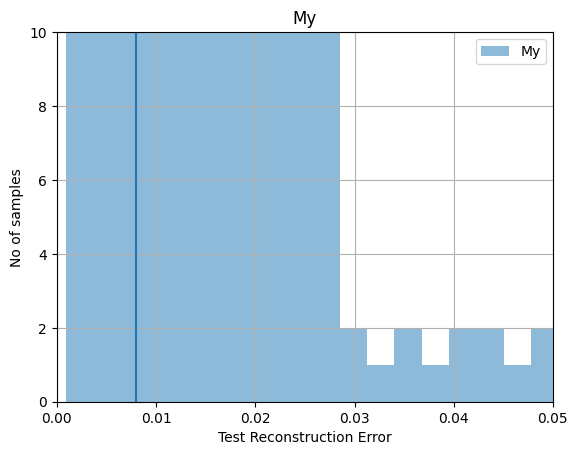

In [75]:
val = 4 # different features

# thresh_100 =[0.12058696399818704, 0.17141290128585543, 0.14004766570118113, 0.16121761305331384, 0.17772109423329138]
# thres_9975 = [0.0709026536395064, 0.07602603667000414, 0.07353850809331126, 0.08007051406779918, 0.07487183085707738]
# thres_99 = [0.05233434515209344, 0.05290230868605859, 0.056464039036797566, 0.05137648441954252, 0.05237976169998783]
# thres_98 =[0.04567557852106737, 0.04400684972560172, 0.04850839262375138, 0.04281574787582381, 0.044593179947201814]
# thres_95 =[0.03781616013334753, 0.03487066640099267, 0.038698132654038056, 0.034836781207393114, 0.03655065661342158]

# thresh_100 =[0.13035238744140548, 0.21007424693886956, 0.16367017245568877, 0.1762440252573822, 0.16476034570752712]
# thres_9975 = [0.0967004598974419, 0.09869261265760929, 0.11111542768823458, 0.09881092549212814, 0.10353092904987385]
# thres_99 = [0.07677684221241628, 0.0787098484051938, 0.08990352195527371, 0.07747489365990633, 0.07989175145593347]
# thres_98 =[0.06836203745416794, 0.06930030473266582, 0.07856424432710564, 0.06824051788679626, 0.07116663246070548]
# thres_95 =[0.057640338431680725, 0.05795949035854773, 0.06548859677927252, 0.05594122231148879, 0.05955018884732331]

plt.figure()
plt.title(feature_list[val])
# plt.axvline(x=thres_95[val], linestyle='-',color='b',label='$95$%')
# plt.axvline(x=thres_98[val], linestyle='-',color='k',label='$98$%')
# plt.axvline(x=thres_99[val], linestyle='-',color='r',label='$99$%')
# plt.axvline(x=thres_9975[val], linestyle='-',color='g',label='$99.75$%')
# plt.axvline(x=thres_100[val], linestyle='--',color='r',label='$100$%')
plt.axvline(x=0.008)
plt.xlabel('Test Reconstruction Error')
plt.ylabel('No of samples')
plt.hist(test_mae_loss[:,val], bins=50, label=f"{feature_list[val]}",alpha=0.5)
plt.ylim(0, 10)
plt.xlim(0, 0.05)
plt.legend()
plt.grid()
plt.show()

### Using Threshold (global/local) 

In [76]:
thresholds = [0.1799126027528948, 0.14092728424592504, 0.28272036771203113, 0.04349732973700156, 0.06191610826630403]

In [77]:
method = 'local'
#using individual threshold
anomalies_list = []
anomalies_idx_list = []
for i in range(test_mae_loss.shape[1]):
    temp_anomaly = (test_mae_loss[:,i] > thresholds[i]).tolist()
    anomalies_list.append(temp_anomaly)
    anomalies_idx_list.append(np.where(temp_anomaly)[0])

    print(f"Number of anomaly samples for #{i+1} which is {feature_list[i]}: ", np.sum(temp_anomaly))
    print("Indices of anomaly samples: ", np.where(temp_anomaly)[0])
    print()
    

Number of anomaly samples for #1 which is Fx:  68
Indices of anomaly samples:  [2419 2420 2421 2422 2423 2424 2425 2426 2427 2428 2429 2430 2431 2432
 2433 2434 2435 2436 2437 2438 2439 2440 2441 2442 2443 2444 2445 2446
 2447 2448 2449 2450 2451 2452 2453 2454 2455 2456 2457 2458 2459 2460
 2461 2462 2463 2464 2465 2466 2467 2468 2469 2470 2471 2472 2473 2474
 2475 2476 2477 2478 2479 2480 2481 2482 2483 2484 2485 2486]

Number of anomaly samples for #2 which is Fy:  20
Indices of anomaly samples:  [2429 2430 2431 2432 2433 2434 2435 2436 2437 2438 2439 2440 2459 2460
 2461 2462 2463 2464 2465 2466]

Number of anomaly samples for #3 which is Fz:  0
Indices of anomaly samples:  []

Number of anomaly samples for #4 which is Mx:  48
Indices of anomaly samples:  [2423 2424 2425 2426 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436
 2437 2438 2439 2440 2441 2442 2443 2444 2445 2446 2447 2448 2449 2450
 2451 2452 2453 2454 2455 2456 2457 2458 2459 2460 2461 2462 2463 2464
 2465 2466 2467 2

In [78]:
all_indexes = np.concatenate(anomalies_idx_list)

### Display detected anomalies per feature

REMINDER
* `reconstruction_loss < threshold `: **normal**
* `reconstruction_loss > threshold `: **anomaly**

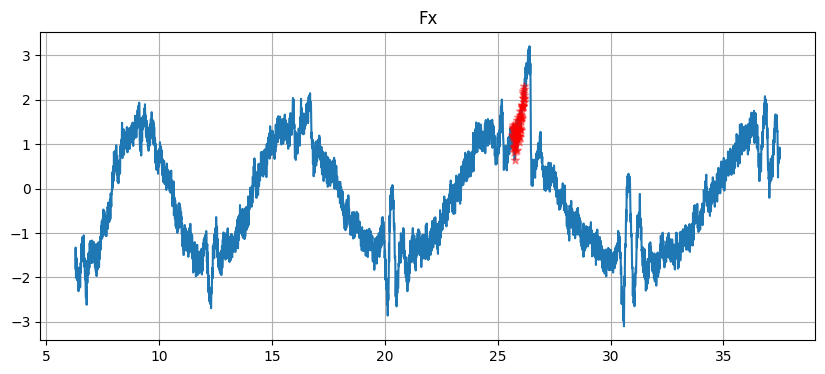

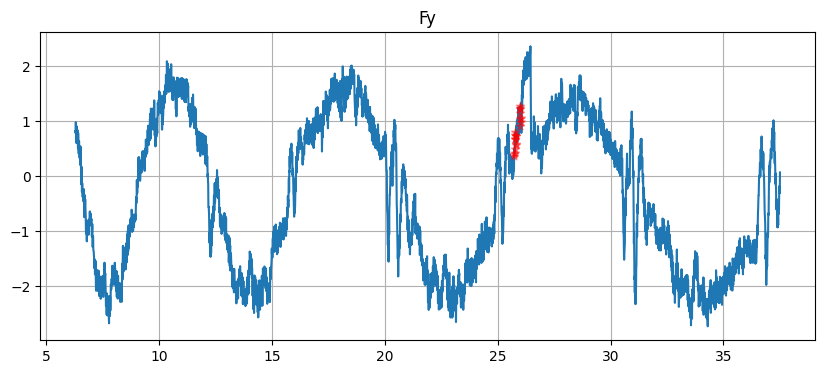

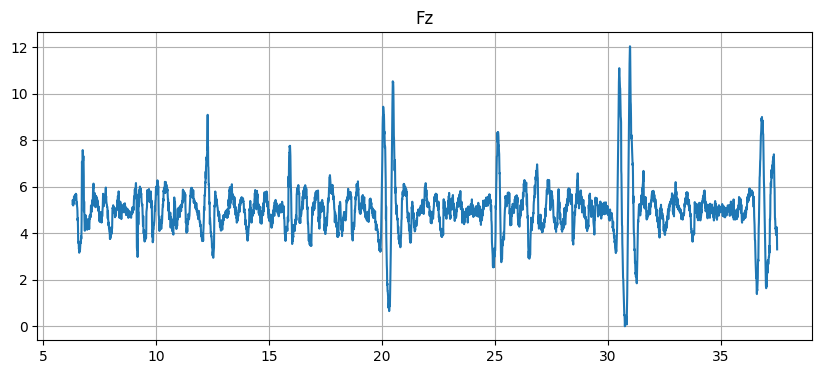

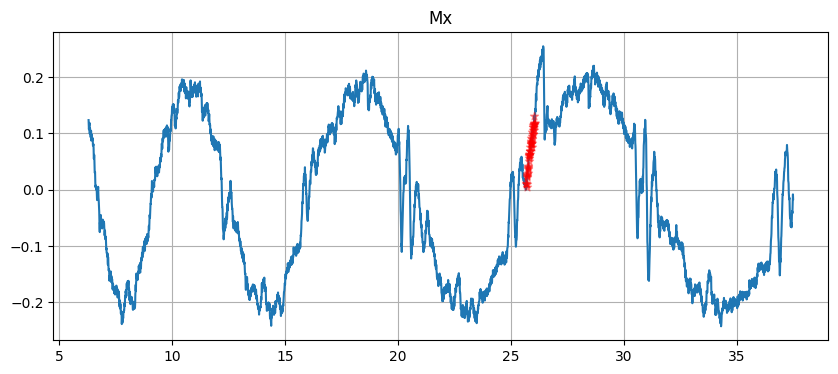

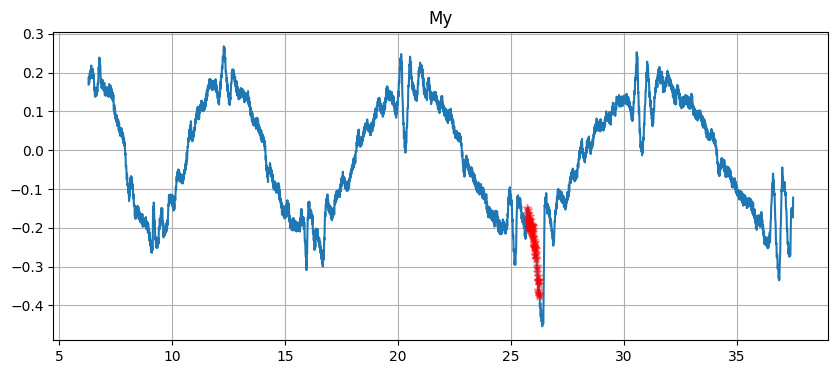

In [79]:
for i in range(len(feature_list)):
    plt.figure(figsize=(10,4))
    name = str(feature_list[i])
    plt.title(name)
    plt.plot(df_testing_data.t, df_testing_data[name])
    for k in anomalies_idx_list[i]:
        plt.scatter(df_testing_data.t.loc[k], df_testing_data[name].loc[k],marker='*', color='red', zorder=12, alpha=0.4)
    plt.grid()
    plt.show()


### Some exploration of the values

#### 1. Chosing earliest detection in any of the features

In [ ]:
# finding earliest detection of anomaly for each feature separately
smallest_idx = 0
smallest_idx_list = []
for i in range(test_mae_loss.shape[1]):
    if anomalies_idx_list[i].size <= 0:
        print(f"Smallest index for #{i+1} doesnt exist, as the array is empty!")    
    else: 
        min_index = min(anomalies_idx_list[i])
        print(f"Smallest index for #{i+1} is {min_index}")
        smallest_idx_list.append(min_index)
    
print()
if smallest_idx_list:
    smallest_idx = min(smallest_idx_list)
else:
    print('All arrays are empty')
print('Resulting smallest index: ',smallest_idx)

#### 2. Chosing earliest detection thats shared among ALL of the features

#### 3. Chosing earliest detection thats shared among majority of the features i.e. if feature number = 3, then at least 2 share

In [ ]:
import math

In [ ]:
n_features = len(feature_list)
# round up to the nearest whole number to define majority
n_majority = math.ceil(n_features/2)
n_majority = 2
print('Majority =',n_majority)

In [ ]:
majority_index = sorted_repeated_values(all_indexes, n_majority)

In [ ]:
majority_index

## Approach #3 - use index that shared across at least the majority of the features
In case of using 3 features, index has to be shared at least among the 2 of them.

In [ ]:
print(majority_index)
start = min(majority_index)
end = max(majority_index)

In [ ]:
for feature in feature_list:
    fig, axs = plt.subplots(2,1,figsize=(16,10))
    axs[0].plot(df_testing_data.t, df_testing_data[feature],label='detected anomaly')
    axs[0].axvline(x=df_testing_data.t.loc[start], linestyle='--',color='r',label='threshold')
    for i in majority_index:
        axs[0].scatter(df_testing_data.t.loc[i], df_testing_data[feature].loc[i],
                       marker='*', color='red', zorder=12, alpha=0.5)
    axs[0].legend(loc='upper right')
    axs[0].grid()
    axs[0].set_title(f'{feature} [N]')

    axs[1].plot(df_testing_data.t, df_testing_data[feature],label='real anomaly')
    axs[1].axvline(x=df_testing_data.t.loc[start], linestyle='--',color='r',label='threshold')
    for i in one_occurace:
        axs[1].scatter(df_testing_data.t.loc[i], df_testing_data[feature].loc[i],
                       marker='*', color='orange', zorder=12, alpha=0.5)
    axs[1].legend(loc='upper right')
    axs[1].grid()
    plt.show()
    
plt.figure(figsize=(16,4))
plt.title('Case')
plt.scatter(df_testing_data.t, df_testing_data.Case)
plt.axvline(x=df_testing_data.t.loc[start], linestyle='--',color='r',label='threshold')
plt.grid()
plt.show()

In [ ]:
total = len(df_testing_data)

In [ ]:
df_testing_data.t.loc[total-1]

In [ ]:
df_testing_data.t.loc[start]